<a href="https://colab.research.google.com/github/BrendaLoznik/breeding_bird_CBS_API/blob/main/CBS_API_Broedvogels_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INTRODUCTION**

**ABOUT THE CBS API**

CBS (Centraal Bureau voor de Statistiek – Statistics Netherlands) provides reliable statistical information and data to provide insight into social issues. The 0DATA API allows users to consistently access this data using R or Python.. Checking the metadata allows you to observe the variables present in the table. Tables can be easily merged using the provided MeasureCodes and titles. Click [here](https://www.cbs.nl/nl-nl/onze-diensten/open-data/open-data-v4/snelstartgids-odata-v4) for more information on the 0DATA API.

**ABOUT THE DATASET**

[The breeding birds dataset](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=84563NED&_theme=221 ) gives information on the breeding trends of endemic species that regularly breed in The Netherlands. Trends are available from 1990 onwards (index = 100). The data is derived using different sampling methods. Mapping breeding pairs in 50-200 hectare grids is a commonly used method.

The data in this dataset represent indexes per year. The increase in numbers is classified as ‘strong’ when an average of 5% increase in breeding pairs is observed over a 12-year period. A strong decline indicates an average 5% decrease in breeding pair numbers over this same time frame.



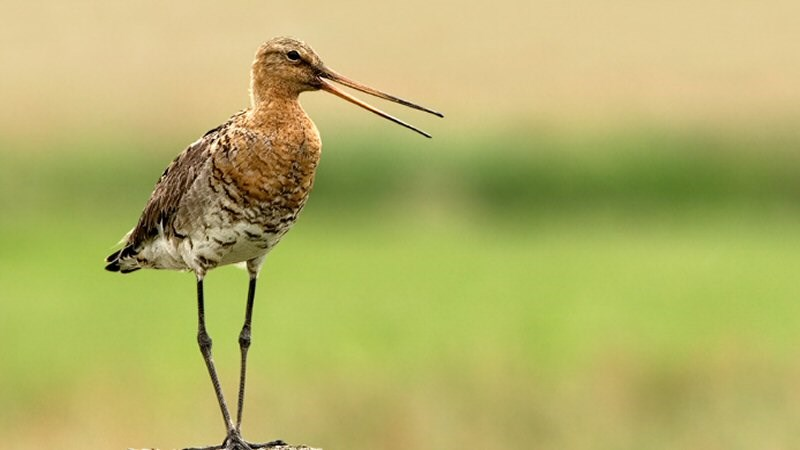

## **LOAD LIBRARIES**

In [ ]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)

##**DOWNLOADING THE TABLES FROM API**

In [ ]:
#Define a function to extract data from the CBS API
def get_odata(target_url):
    data = pd.DataFrame()
    while target_url:
        r = requests.get(target_url).json()
        data = data.append(pd.DataFrame(r['value']))
        
        if '@odata.nextLink' in r:
            target_url = r['@odata.nextLink']
        else:
            target_url = None   
    return data

In [ ]:
#check metadata
get_odata('https://beta-odata4.cbs.nl/CBS/84498NED')

,name,kind,url
0,MeasureCodes,EntitySet,MeasureCodes
1,Dimensions,EntitySet,Dimensions
2,PeriodenGroups,EntitySet,PeriodenGroups
3,PeriodenCodes,EntitySet,PeriodenCodes
4,BroedvogelsGroups,EntitySet,BroedvogelsGroups
5,BroedvogelsCodes,EntitySet,BroedvogelsCodes
6,Observations,EntitySet,Observations
7,Properties,Singleton,Properties


In [ ]:
table_url = "https://beta-odata4.cbs.nl/CBS/84498NED"

#download 100.000 observations from the url
target_url = table_url + "/Observations?$top=100000"
data = get_odata(target_url)

data.head()

In [ ]:
#check the available tables
codes = get_odata(table_url + "/MeasureCodes")
dimensions = get_odata(table_url + "/Dimensions")
periodengroups = get_odata(table_url + "/PeriodenGroups")
broedvogel = get_odata(table_url + "/BroedvogelsCodes")
observations = get_odata(table_url + "/Observations")
period = get_odata(table_url + "/PeriodenCodes")
broedgroep = get_odata(table_url + "/BroedvogelsGroups")
broedvogelsCodes = get_odata(table_url + "/BroedvogelsCodes")

### **DATASET PREPARATION**

In [ ]:
#add the birdname from the "broedvogelsCodes" table
data = pd.merge(data, broedvogelsCodes[["Identifier", "Title"]], left_on = "Broedvogels", right_on = "Identifier")
data.tail(3)

,Id,Measure,ValueAttribute,Value,Perioden,Broedvogels,Identifier,Title
5026,5043,M006964,None,75.0,2016JJ00,A006953,A006953,Zwartkopmeeuw
5027,5044,M006964,None,156.0,2017JJ00,A006953,A006953,Zwartkopmeeuw
5028,5045,M006964,None,100.0,2018JJ00,A006953,A006953,Zwartkopmeeuw


In [ ]:
#add the years from the "period" table
data = pd.merge(data, period[["Identifier", "Title"]], left_on = "Perioden", right_on = "Identifier")
data.tail(3)

,Id,Measure,ValueAttribute,Value,Perioden,Broedvogels,Identifier_x,Title_x,Identifier_y,Title_y
5026,4987,M006964,None,92.0,2018JJ00,A006950,A006950,Zwarte Stern,2018JJ00,2018
5027,5016,M006964,None,236.0,2018JJ00,A006952,A006952,Zwartkop,2018JJ00,2018
5028,5045,M006964,None,100.0,2018JJ00,A006953,A006953,Zwartkopmeeuw,2018JJ00,2018


In [ ]:
#drop redundant features and rename the columns for clarity
data = data.drop(['Id', 'Measure', 'ValueAttribute', 'Perioden', 'Broedvogels', 'Identifier_x', "Identifier_y"], axis=1)
data.rename(columns = {"Title_x": "Species", "Title_y": "Year"}, inplace = True)
data.tail()

,Value,Species,Year
5024,95.0,Zwarte Roodstaart,2018
5025,80.0,Zwarte Specht,2018
5026,92.0,Zwarte Stern,2018
5027,236.0,Zwartkop,2018
5028,100.0,Zwartkopmeeuw,2018


**OBSERVED TRENDS**

Select Species of Interest: Grauwe Gors


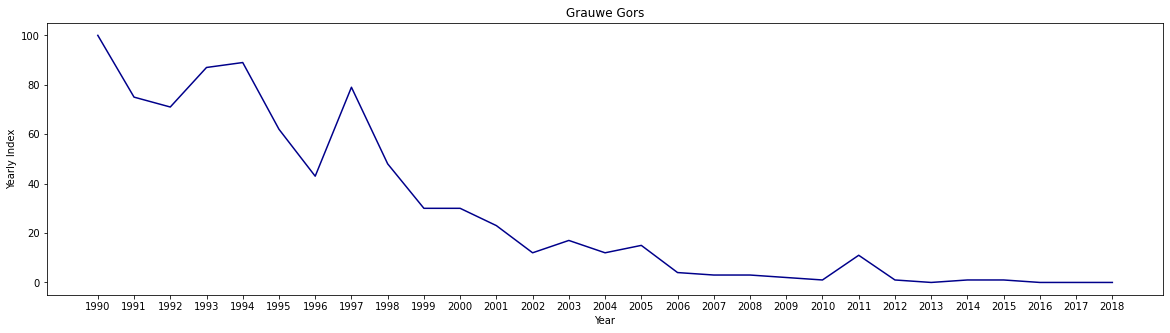

In [ ]:
#SELECT SPECIES OF INTEREST
selection = input("Select Species of Interest: ") 



#check validity of selected species 
option = set(data["Species"])
while selection not in option:
   print("Not a valid species")
   selection = input("Select Species of Interest: ") 
   if selection in option:
     break

#plot the selected species
fig, ax = plt.subplots(figsize=(20,5)) 
species = data[data["Species"] == selection]
sns.lineplot(x="Year", y = "Value",  data = species, color = "darkblue")
ax.set (ylabel = "Yearly Index", title = selection)
plt.show()

**TIME SERIES**

In [ ]:
series = data.pivot(index = "Species", columns = "Year", values = "Value")
series.head(10)

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Species,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aalscholver,100.0,104.0,112.0,110.0,80.0,90.0,100.0,94.0,107.0,101.0,108.0,108.0,124.0,124.0,110.0,125.0,128.0,116.0,116.0,127.0,132.0,112.0,128.0,108.0,113.0,100.0,118.0,117.0,108.0
Appelvink,100.0,102.0,110.0,104.0,113.0,131.0,130.0,158.0,112.0,96.0,102.0,100.0,99.0,108.0,91.0,104.0,104.0,107.0,124.0,122.0,124.0,143.0,164.0,181.0,195.0,212.0,227.0,233.0,266.0
Baardman,100.0,116.0,194.0,210.0,170.0,172.0,123.0,129.0,114.0,96.0,147.0,119.0,123.0,122.0,143.0,98.0,121.0,138.0,134.0,141.0,142.0,88.0,96.0,119.0,161.0,144.0,116.0,160.0,128.0
Bergeend,100.0,104.0,109.0,102.0,116.0,116.0,111.0,133.0,138.0,120.0,127.0,128.0,130.0,125.0,120.0,125.0,126.0,116.0,118.0,123.0,128.0,131.0,139.0,144.0,150.0,138.0,133.0,132.0,111.0
Blauwborst,100.0,106.0,126.0,141.0,141.0,189.0,161.0,180.0,194.0,195.0,188.0,195.0,204.0,227.0,268.0,230.0,207.0,223.0,209.0,229.0,282.0,319.0,330.0,307.0,326.0,330.0,353.0,310.0,334.0
Blauwe Kiekendief,100.0,91.0,83.0,79.0,71.0,58.0,49.0,51.0,51.0,42.0,45.0,49.0,39.0,33.0,28.0,25.0,24.0,18.0,18.0,13.0,21.0,19.0,17.0,10.0,17.0,12.0,11.0,11.0,9.0
Blauwe Reiger,100.0,88.0,87.0,90.0,96.0,102.0,80.0,74.0,79.0,89.0,94.0,98.0,100.0,91.0,92.0,95.0,90.0,92.0,90.0,83.0,73.0,69.0,65.0,53.0,60.0,72.0,72.0,72.0,66.0
Boerenzwaluw,100.0,87.0,73.0,63.0,50.0,49.0,56.0,58.0,66.0,68.0,71.0,61.0,53.0,59.0,64.0,67.0,80.0,77.0,78.0,82.0,85.0,86.0,68.0,74.0,85.0,86.0,89.0,96.0,95.0
Bontbekplevier,100.0,74.0,104.0,77.0,85.0,95.0,91.0,86.0,100.0,106.0,97.0,103.0,90.0,100.0,100.0,96.0,88.0,96.0,83.0,82.0,90.0,94.0,74.0,68.0,64.0,65.0,74.0,69.0,67.0


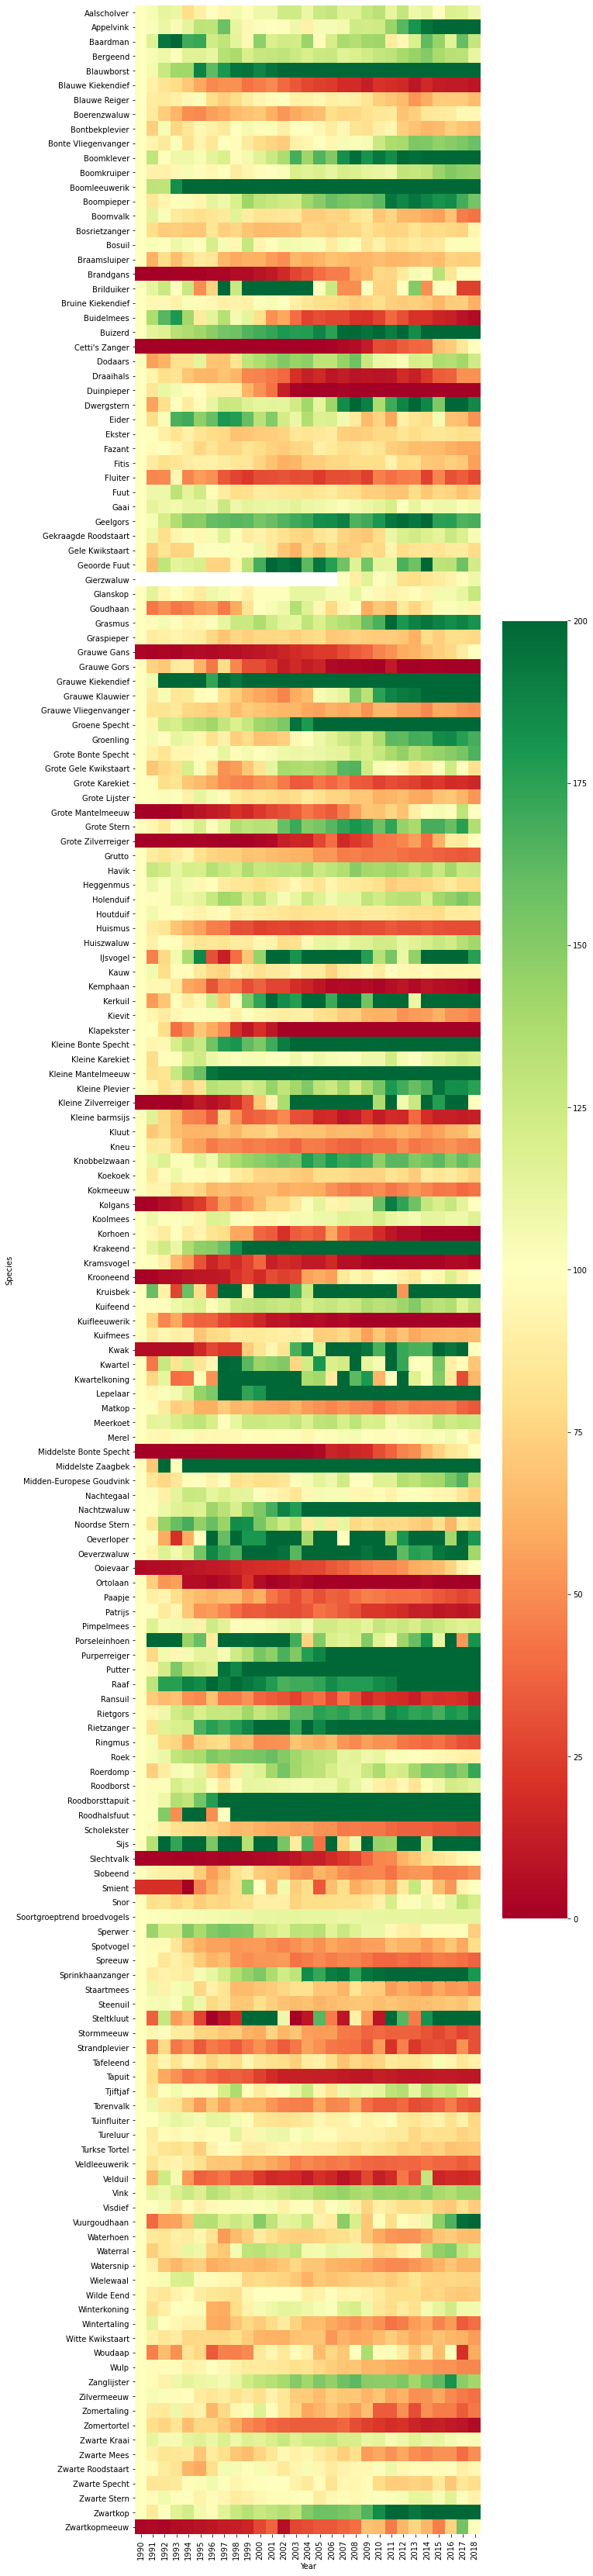

In [ ]:
#Heatmap of reproductive index over time.
#Note: the values are centered around 100 (index of base year 1990) with a maximum index of 200. Higher values do occur.
plt.figure(figsize=(10, 60))
sns.heatmap(series, annot=False, cmap='RdYlGn', center = 100, vmin=0, vmax=200)
plt.show()


**12 YEAR TREND**

In [ ]:
#select the last 12 year of the dataframe
twelve_year_trend  = series.loc[:, '2007':'2018']
twelve_year_trend.head(5)

Year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Species,,,,,,,,,,,,
Aalscholver,116.0,116.0,127.0,132.0,112.0,128.0,108.0,113.0,100.0,118.0,117.0,108.0
Appelvink,107.0,124.0,122.0,124.0,143.0,164.0,181.0,195.0,212.0,227.0,233.0,266.0
Baardman,138.0,134.0,141.0,142.0,88.0,96.0,119.0,161.0,144.0,116.0,160.0,128.0
Bergeend,116.0,118.0,123.0,128.0,131.0,139.0,144.0,150.0,138.0,133.0,132.0,111.0
Blauwborst,223.0,209.0,229.0,282.0,319.0,330.0,307.0,326.0,330.0,353.0,310.0,334.0


In [ ]:
#caclulate the mean index over the last 12 years
twelve_year_trend['12YrMean'] = round(twelve_year_trend.mean(axis=1),1)


In [ ]:
#Add label based on 12 year average trend
twelve_year_trend["Label"] = twelve_year_trend["12YrMean"].apply(lambda x: "Strong increase" if x > 105  
                                                                 else "Medium increase" if x > 102
                                                                 else "Strong decrease" if x < 95
                                                                 else "Medium decrease"if x < 98
                                                                 else "Stable")
twelve_year_trend.head()

In [ ]:
#91 species show a strong decrease over the last 12 years
number = twelve_year_trend["Label"].value_counts()
number

Strong decrease    91
Strong increase    71
Medium increase     5
Stable              4
Medium decrease     3
Name: Label, dtype: int64

**SPECIES WITH THE LARGEST INCREASE AND DECLINE OVER THE PAST 12 YEARS**

In [ ]:
twelve_year_trend.nsmallest(5, "12YrMean")

Year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,12YrMean,Label
Species,,,,,,,,,,,,,,
Klapekster,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Strong decrease
Duinpieper,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,Strong decrease
Ortolaan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.2,Strong decrease
Kuifleeuwerik,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,Strong decrease
Grauwe Gors,3.0,3.0,2.0,1.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.9,Strong decrease


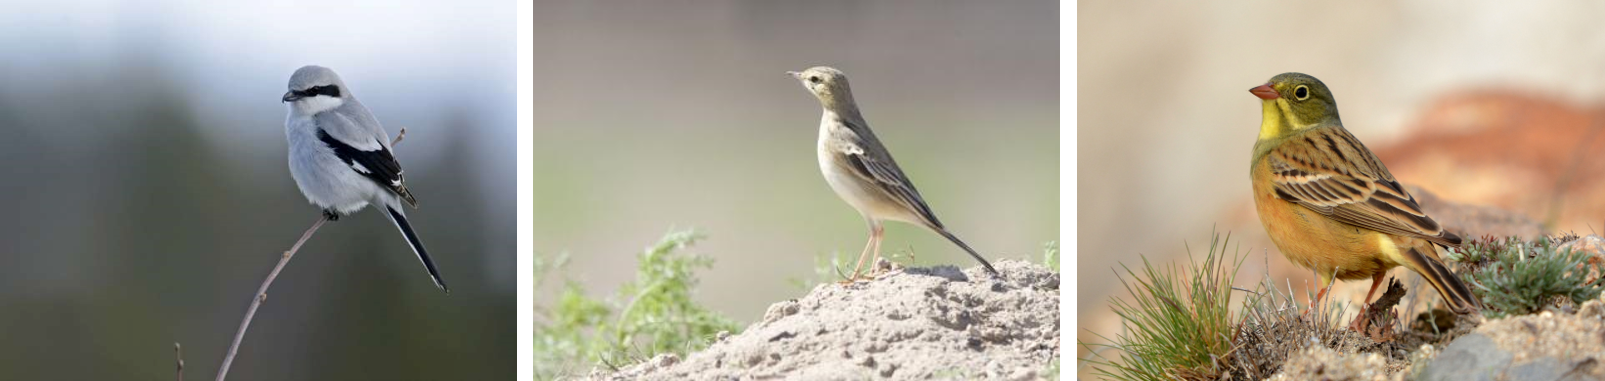

In [ ]:
twelve_year_trend.nlargest(5, "12YrMean")

Year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,12YrMean,Label
Species,,,,,,,,,,,,,,
Roodborsttapuit,421.0,471.0,513.0,588.0,793.0,840.0,652.0,789.0,825.0,902.0,804.0,779.0,698.1,Strong increase
Krakeend,411.0,450.0,508.0,524.0,512.0,571.0,629.0,618.0,700.0,695.0,644.0,728.0,582.5,Strong increase
Putter,420.0,349.0,402.0,558.0,512.0,642.0,536.0,661.0,703.0,629.0,776.0,682.0,572.5,Strong increase
Roodhalsfuut,450.0,600.0,500.0,450.0,500.0,450.0,600.0,500.0,650.0,700.0,450.0,690.0,545.0,Strong increase
Lepelaar,328.0,349.0,403.0,429.0,469.0,449.0,452.0,507.0,516.0,546.0,600.0,571.0,468.2,Strong increase


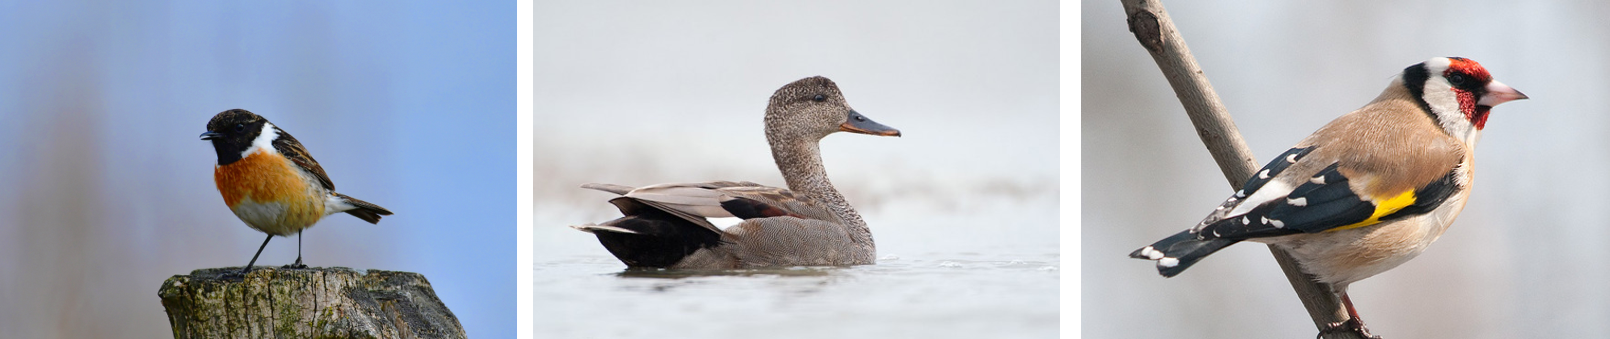